In [29]:
## Jupyter extensions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Interweaving RL, IRL steps, like an IRL Algorithm.

What does it buy us? 

In [2]:
# First, set everything up.
#start by adding parent directory...
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [3]:
# Now build environment
# import numpy as np
import torch
import numpy
import primitives as prim
from environs import GridWorld
from utils import broadcompress

GW = GridWorld.make(12,8, noise=0.1)
R1pt = torch.zeros(GW.Sshape)
R1pt[21] = 2

# torch.tensor(GW.T.to_numpy()).reshape(GW.Tshape)

assert numpy.allclose(GW._T, GW.T.to_numpy().reshape(GW.Tshape)), "NOT CLOSE"


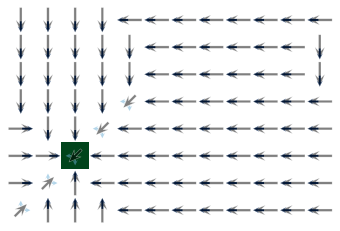

In [4]:
pi0 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=20, val_iters=30, temp=0)
GW.draw(states=R1pt, policy=pi0)

here's the same thing with a higher temperature

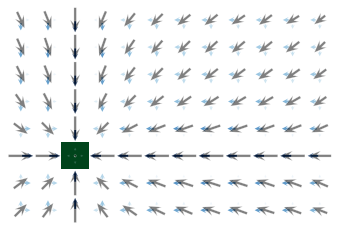

In [5]:
pi01 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=20, val_iters=30, temp=0.01)
GW.draw(states=R1pt, policy=pi01)

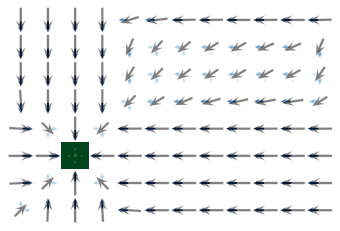

In [6]:
# An intermediate, slightly lower temperature
pi001 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=20, val_iters=30, temp=0.001)
GW.draw(states=R1pt, policy=pi001)

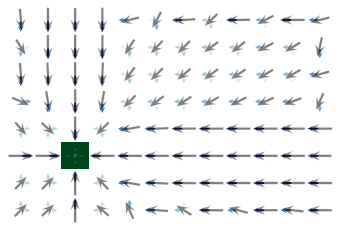

In [7]:
# Changing $\gamma$. For very close to 1, becomes sensitive to parity.
pi9999 = prim.fwd(GW, R1pt, 0.9999, policy_improve_iters=31, val_iters=50, temp=0.001)
GW.draw(states=R1pt, policy=pi9999)

states: log visitation probability, 1000 iters
policy: optimal for point reward.


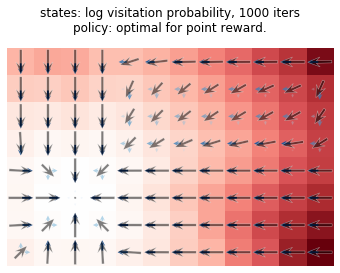

In [11]:
# V = prim.value_iter(GW, R1pt, 0.9, temperature=0.001)
#pi = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=30, val_iters=50, temp=0.01)
D = prim.visitation_iter(GW, pi9999, iters=1000)

GW.draw(states=torch.log(D), policy = pi001,descr=
"""states: log visitation probability, 1000 iters
policy: optimal for point reward."""
)

In [8]:
from dist import RawJointDist as RJD

policy: optimal for novelty reward. states: log novelty reward


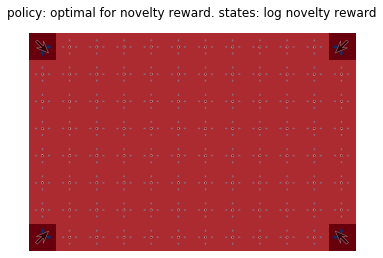

In [13]:
R = GW.novelty
V = prim.value_iter(GW, R, 0.9, temperature=0.01)
pi = prim.fwd(GW, R, 0.9, policy_improve_iters=30, val_iters=50, temp=0.01)
D = prim.visitation_iter(GW, pi, iters=1000)

GW.draw(states=torch.log(D), policy = pi, descr="""policy: optimal for novelty reward. states: log novelty reward""")

If the reward and policy already match for the same temperature, then it should do nothing.

In [31]:
#DEBUGGING. 
# Currently, adjust_both should just be doing the same thing as 
# fwd, yet they give different results.
from viz import pca_view
# import numpy as np

πopt = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=100, val_iters=100, temp=0.01)

π0 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=0, val_iters=30, temp=0.01)
π1 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=1, val_iters=30, temp=0.01)
π2 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=2, val_iters=30, temp=0.01)

#π2 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=12, val_iters=30, temp=0.01)

π1prime, _ = prim.adjust_both(GW, π0, R1pt, 0.9, value_iters=30, iters=1, temp=0.01)
π2prime, _ = prim.adjust_both(GW, π0, R1pt, 0.9, value_iters=30, iters=2, temp=0.01)


print("max policy dist  (0 -> 1): ", torch.abs(π0-π1).max() )
print("max policy dist  (0 -> 1') ", torch.abs(π1-π1prime).max() )
print("max policy dist  (1 -> 2) ", torch.abs(π1-π2).max() )
print("max policy dist  (0 -> 2') ",torch.abs(π1-π1prime).max() )


max policy dist  (0 -> 1):  tensor(0.0797, dtype=torch.float64)
max policy dist  (0 -> 1')  tensor(0., dtype=torch.float64)
max policy dist  (1 -> 2)  tensor(0.0394, dtype=torch.float64)
max policy dist  (0 -> 2')  tensor(0., dtype=torch.float64)


Explained_variance: [0.95892206 0.04107794] 	(total: 1.000000)


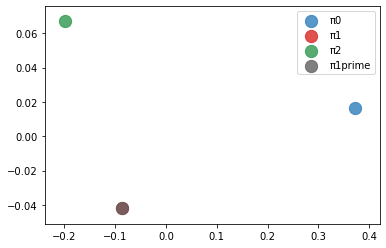

In [34]:

pca_view(π0=[π0], π1 = [π1], π2 = [π2], π1prime=[π1prime])



policy distance:  tensor(0.0214, dtype=torch.float64)
reward distance:  tensor(0.)


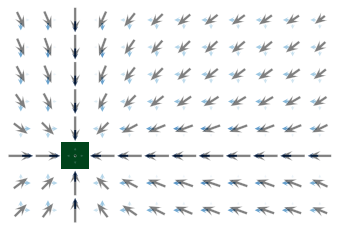

In [36]:
π_old = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=30, 
                 val_iters=60, temp=0.01)
# Test a version of adjusting.
π_new, ρ_new = prim.adjust_both(GW, π_old, R1pt, 0.9, temp=0.01, 
                                value_iters=60, iters=10)
maxρnew = broadcompress(ρ_new).max(axis=1)
# Dnew = prim.visitation_iter(GW, π_new, iters=200)
GW.draw(states=np.log(1+maxρnew), policy=π_new)

print("policy distance: ", torch.abs(pi01-π_new).max() )
print("reward distance: ", torch.abs(R1pt-ρ_new).max() )

#assert np.allclose(pi, π_new)
#assert np.allclose(R1pt, ρ_new, atol=2E-8)

This gets thrown off by extremal values (presumably due to numerical error?)

In [ ]:
# Test a version of adjusting.

π_new, ρ_new = prim.adjust_both(GW, pi9999, R1pt, 0.9999, temp=0.001)

In [ ]:
maxρnew = broadcompress(ρ_new).max(axis=1)
Dnew = prim.visitation_iter(GW, π_new, iters=200)
GW.draw(states=np.log(Dnew), policy=π_new)

Note that in the case where the policy and reward do not match (here, a random policy), the operation does something (not insignificant, but local) to both.

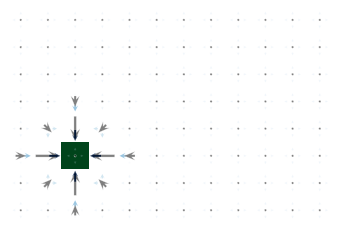

In [40]:
π_new, ρ_new, trace = prim.adjust_both(GW, GW.random_policy(det=False), R1pt, 0.1, 
                                       temp=0.01, store_iters="DπρV", iters=30)

maxρnew =  broadcompress(ρ_new).max(axis=1)
GW.draw(states=maxρnew, policy=π_new)

Let's now visualize the trace, by plotting a PCA of policy over time

Explained_variance: [nan nan] 	(total: nan)


/home/oli/.local/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


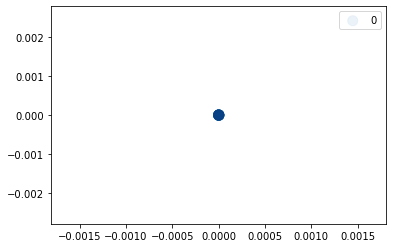

In [44]:
pca_view(trace['ρ'])


Explained_variance: [0.99894045 0.0010595 ] 	(total: 1.000000)


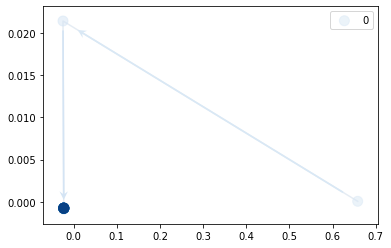

In [43]:
pca_view(trace['π'])